# Hugget Economy and Behavioral Frictions

In this notebook, I solve the second exercise in the Problem Set 4. Clearly, the notebook is inspired in the Sequence Jacobian Repo: https://github.com/shadeecon/sequence-jacobian.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from sequence_jacobian import drawdag, JacobianDict

## 1. Model description
The model can be written in sequence space as
$$
H_t(\textbf{r}, \textbf{Y}) \equiv 
\mathcal{A}_t(\{r_s, Y_s\}_{s\geq 0}) 
=  0  
\qquad t = 0, 1, \dots
$$

where the (aggregate) endogenous variable is $\textbf{r} = \{r_s\}$ and the only exogenous variable is $\textbf{Y}=\{Y_s\}$.  The aggregate asset function $\mathcal{A}$ follows from the household block characterized by the Bellman equation
$$
\begin{align*}
V_t(s, a_{-}) = \max_{c, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t\left[V_{t+1}(s', a)|s \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + s Y_t 
\\
a &\geq \underline{a}
\end{align*}
$$

We can represent this model as a Directed Acyclic Graph (DAG) in just one unknown $\textbf{r}$ and one target, asset market clearing: $H_t(\textbf{r}, \textbf{Y})=0$.

## 2. Set Up Heterogeneous-Agent Block

Solving a HA problem consists of 3 distinct steps.
1. **backward iteration**: solve for individual policy functions
2. **forward iteration**: solve for distribution
3. **aggregation**: obtain macro outcomes
   
Next, we need first define the HA block as follows.

In [2]:
def household_init(a_grid, e_grid, r, Y, eis):
    coh = (1 + r) * a_grid[np.newaxis, :] + Y * e_grid[:, np.newaxis]
    Va  = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va

@het( exogenous='Pi', policy='a', backward='Va', backward_init=household_init )
def household(Va_p, a_grid, e_grid, r, Y, beta, eis):
    """
    Single backward iteration step using endogenous gridpoint method for households with CRRA utility

    Parameters
    ----------
    Va_p     : array (nE, nA), expected marginal value of assets next period
    a_grid   : array (nA), asset grid
    e_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    Y        : scalar, Output
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (nE, nA), marginal value of assets today
    a  : array (nE, nA), asset policy today
    c  : array (nE, nA), consumption policy today
    """
    
    uc_nextgrid = beta * Va_p
    c_nextgrid  = uc_nextgrid ** (-eis)
    coh         = (1 + r) * a_grid[np.newaxis, :] + Y * e_grid[:, np.newaxis]
    a           = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    misc.setmin(a, a_grid[0])
    c           = coh - a
    Va          = (1 + r) * c ** (-1 / eis)
    return Va, a, c

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, _, Pi = grids.markov_rouwenhorst( rho=rho_e , sigma=sd_e , N=nE )
    a_grid        = grids.agrid( amin=amin, amax=amax, n=nA )
    return e_grid, Pi, a_grid


household_ext = household.add_hetinputs( [make_grid] )

print(household_ext)
print(f'Inputs: {household_ext.inputs}')
print(f'Macro outputs: {household_ext.outputs}')
print(f'Micro outputs: {household_ext.internals}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'Y', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'e_grid', 'a_grid']


## 3. Rest of the Model and DAG

The additional block that constitute the Hugget model is the market clearing conditions. Moreover, we also plot the DAG of the model.

['r', 'Y', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']
['A', 'C', 'asset_mkt', 'good_mkt']


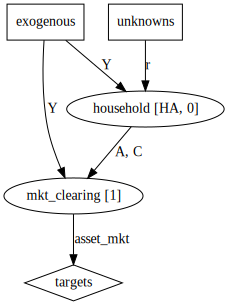

In [3]:
@simple
def mkt_clearing(A,Y,C):
    asset_mkt = A
    good_mkt  = Y - C
    return asset_mkt, good_mkt

hugget    = create_model([household_ext, mkt_clearing], name="Hugget")

print(hugget.inputs)
print(hugget.outputs)

exogenous = ["Y"]
unknowns  = ["r"]
targets   = ["asset_mkt"]
drawdag(hugget, exogenous, unknowns, targets, save=True)


## 4. Calibrating the Steady State

Next, we calibrate the model in general equilibrium. We use the calibration in the Problem Set 1.

In [4]:
calibration = {'eis': 1, 'Y': 1.0, 'beta': 0.98, 'rho_e': 0.975, 'sd_e': 0.7,
               'nE': 7,   'nA': 500, 'amin': -1.0, 'amax': 200}
unknowns_ss = {'r': 0.01}
targets_ss  = {'asset_mkt': 0.}
ss          = hugget.solve_steady_state( calibration , unknowns_ss, targets_ss, solver = "hybr"  )

print(ss)
print( f"Annual Interest Rate (%): {100*4*ss['r']}" )
print( f"Asset market clearing: {ss['asset_mkt']}" )
print( f"Good market clearing: {ss['good_mkt']}" )

<SteadyStateDict: ['eis', 'Y', 'beta', 'rho_e', 'sd_e', 'nE', 'nA', 'amin', 'amax', 'r', 'A', 'C', 'asset_mkt', 'good_mkt'], internals=['household']>
Annual Interest Rate (%): -0.3845552458831266
Asset market clearing: -2.9976021664879227e-15
Good market clearing: -7.110296795787008e-10




Let's plot the consumption policy function for all skill types  as a function of assets.

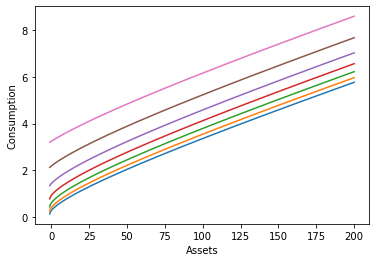

In [5]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

## 4. Jacobians

Now, we are going to use the SeqJac Repo to compute the Jacobians. We can use the direct the approach, but first we are going to do it "manually." From the goods market clearing condition (which is implied by asset clearaing), the IKC-like equation is

$$ d\mathbf{Y} = \mathbf{M}_y d\mathbf{Y} + \mathbf{M}_rd\mathbf{r} $$

where, numeriaclly, the Jacobians $\mathbf{M}_y$ and $\mathbf{M}_r$ are $T$-dimensional (truncated) sequence spaces: a $T \times T$ matrix of the form

$$
\mathbf{M}_x = 
\begin{pmatrix}
\frac{d C_0}{d x_0} & \frac{d C_0}{d x_1} & \dots & \frac{d C_0}{d x_{T-1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d C_{T-1}}{d x_0} & \frac{d C_{T-1}}{d x_1} & \dots & \frac{d C_{T-1}}{d x_{T-1}}
\end{pmatrix}
$$

evaluated at the steady state.

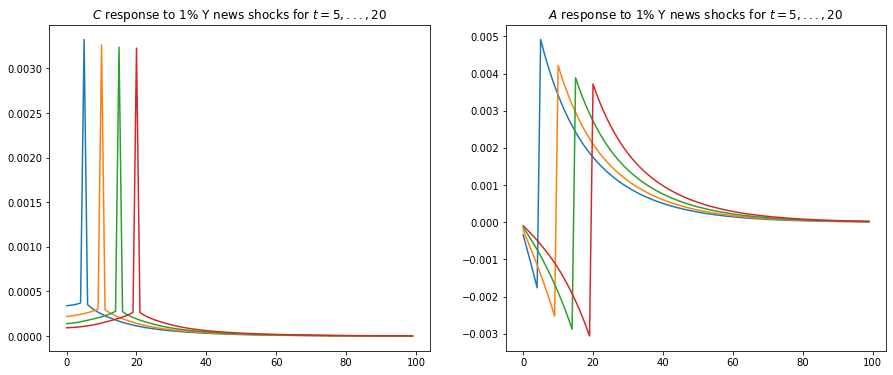

In [6]:
T    = 500
M    = household.jacobian(ss, inputs=['r', 'Y'],T=T)
M_r  = M['C']['r']
M_y  = M['C']['Y']

dY   = 0.01*(np.arange(T)[:, np.newaxis] == np.array([5, 10, 15, 20]))
dC_y = M_y @ dY
dA_y = M['A']['Y'] @ dY
dC_r = M_r @ dY
dA_r = M['A']['r'] @ dY

fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))
axes[0].plot(dC_y[:100])
axes[0].set(title = '$C$ response to 1% Y news shocks for $t=5,...,20$')
axes[1].plot(dA_y[:100])
axes[1].set(title = '$A$ response to 1% Y news shocks for $t=5,...,20$')

plt.show()

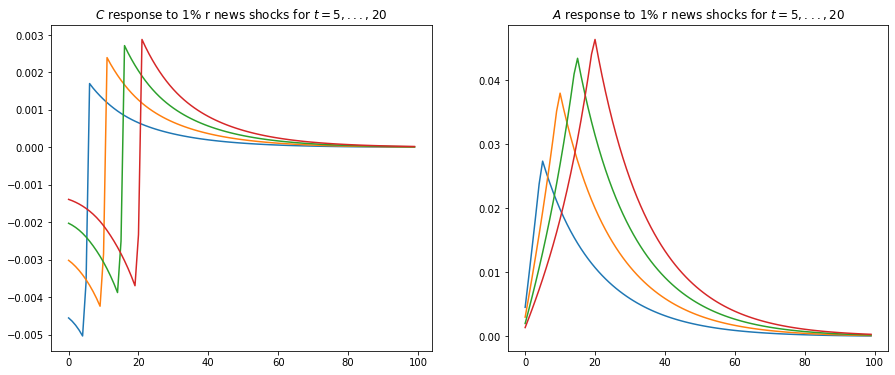

In [7]:
fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))
axes[0].plot(dC_r[:100])
axes[0].set(title = '$C$ response to 1% r news shocks for $t=5,...,20$')

axes[1].plot(dA_r[:100])
axes[1].set(title = '$A$ response to 1% r news shocks for $t=5,...,20$')

plt.show()

## 5. General Equilibrium Responses

The matrix that summarizes the responses of the unknown $\mathbf{r}$ is $\mathbf{G} = \mathbf{M}_r^{-1}(\mathbf{I} - \mathbf{M}_y)$

In [8]:
G0   = {'r': np.linalg.solve( M_r , np.eye(T) - M_y )}

# Direct Approach
inputs   = ['Y']
unknowns = ['r']
targets  = ['good_mkt']
G1       = hugget.solve_jacobian(ss, unknowns, targets, inputs, T=T)

for o in G0:
    assert np.allclose(G1[o]['Y'], G0[o])
    
print(G1)    

<JacobianDict outputs=['r', 'A', 'C', 'asset_mkt', 'good_mkt'], inputs=['Y']>


What do the impulse responses in this model look like? The beauty of our method is that, now that we have $G$, we can compute impulse responses to any shock almost instantaneously, it's just matrix multiplication.

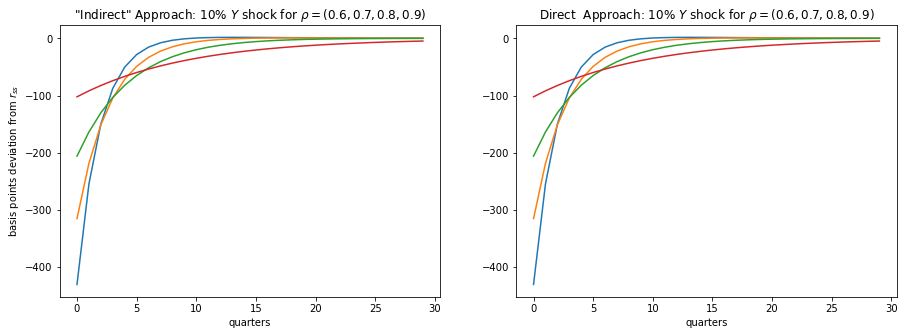

In [9]:
rhos = np.array([0.6, 0.7, 0.8, 0.9])
dY   = 0.1 * ss['Y'] * rhos ** (np.arange(T)[:, np.newaxis])
dr0  = G0['r'] @ dY
dr1  = G1['r']['Y'] @ dY

fig, axes = plt.subplots( 1 , 2 , figsize=(15, 5))
axes[0].plot(10000*dr0[:30, :])
axes[0].set(title  = r'"Indirect" Approach: 10% $Y$ shock for $\rho=(0.6, 0.7, 0.8, 0.9)$', 
            ylabel = r'basis points deviation from $r_{ss}$', xlabel = r'quarters')

axes[1].plot(10000*dr1[:30, :])
axes[1].set(title  = r'Direct  Approach: 10% $Y$ shock for $\rho=(0.6, 0.7, 0.8, 0.9)$', 
            xlabel = r'quarters')

plt.show()

## 6. Behavioral Frictions

Consider now completely myopic households. Then, we need to construct the following Jacobians:

$$
\mathbf{M}^m_x = 
\begin{pmatrix}
\frac{d C_0}{d x_0} & 0 & \dots & 0 \\
\frac{d C_1}{d x_0} & \frac{d C_0}{d x_0} & \dots & 0 \\
\frac{d C_2}{d x_0} & \frac{d C_1}{d x_0} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d C_{T-1}}{d x_0} & \frac{d C_{T-2}}{d x_0} & \dots & \frac{d C_{0}}{d x_{0}}
\end{pmatrix}
$$

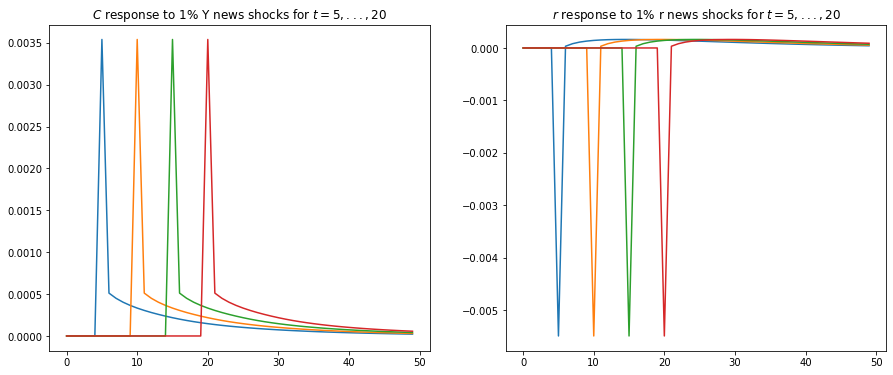

In [10]:
Mm_y = np.zeros([T,T])
Mm_r = np.zeros([T,T])

M0   = M_y[:,0]
for j in range(T):
    Mm_y[j:,j] = M0[0:T-j]
    
M0   = M_r[:,0]
for j in range(T):
    Mm_r[j:,j] = M0[0:T-j]    

dY   = 0.01*(np.arange(T)[:, np.newaxis] == np.array([5, 10, 15, 20]))
dC_y = Mm_y @ dY
dC_r = Mm_r @ dY

fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))
axes[0].plot(dC_y[:50])
axes[0].set(title = '$C$ response to 1% Y news shocks for $t=5,...,20$')
axes[1].plot(dC_r[:50])
axes[1].set(title = '$r$ response to 1% r news shocks for $t=5,...,20$')

plt.show()        

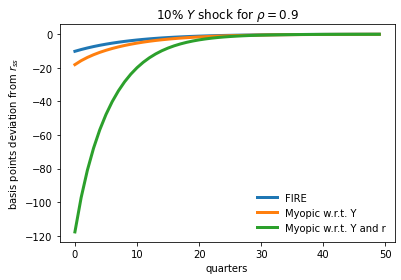

In [11]:
G2   = {'r': np.linalg.solve( M_r , np.eye(T) - Mm_y )}
G3   = {'r': np.linalg.solve( Mm_r , np.eye(T) - Mm_y )}

dr   = np.zeros([T,3])

dY       = 0.01 * ss['Y'] * 0.90 ** (np.arange(T)[:, np.newaxis])
dr[:,0]  = np.transpose( G0['r'] @ dY )
dr[:,1]  = np.transpose( G2['r'] @ dY )
dr[:,2]  = np.transpose( G3['r'] @ dY )

plt.plot( 10000*dr[:50,0] , linewidth=3 , label='FIRE')
plt.plot( 10000*dr[:50,1] , linewidth=3 , label='Myopic w.r.t. Y' )
plt.plot( 10000*dr[:50,2] , linewidth=3 , label='Myopic w.r.t. Y and r' )


plt.title(r'10% $Y$ shock for $\rho= 0.9$')
plt.ylabel(r'basis points deviation from $r_{ss}$')
plt.xlabel(r'quarters')
plt.legend(framealpha=0)
plt.show()

Now, lets construct a function that automatically manipulate Jacobians.

In [12]:
def newM(E,M):
    T  = M.shape[1]
    En = np.vstack([np.zeros([1,T]), E])
    Mn = np.zeros([T,T])    
    for t in range(T):
        for s in range(T):
            ts      = min(t,s)
            aux     = np.diag(M[t-ts:t+1,s-ts:s+1])
            Mn[t,s] =  (En[1:ts+2,s] - En[0:ts+1,s]) @ aux[::-1]
    return Mn 

Consider the "sticky expectations" model (a la Carrol et al (2020)) where the expectation matrix is given by

$$
\mathbf{E} = 
\begin{pmatrix}
1 & 1-\theta & 1-\theta & \dots & 1-\theta \\
1 & 1 & 1-\theta^2 & \dots & 1-\theta^2 \\
\vdots & \vdots & \ddots & \vdots \\
1 & 1 & 1 & \dots & 1
\end{pmatrix}
$$

In [13]:
E     = np.tril( np.ones([T,T]) )
θ     = 0.90

for t in range(T):
    E[t,t+1:] = 1 - θ **(t+1)

Mn_y = newM(E,M_y)  
Mn_r = newM(E,M_r)     

Now, lets compute the general equilibrium effect. The results below show that sticky/myopic expectations with respect to output aggregate does not lead to large deviations from FIRE, but sticky/myopic expectations with respect to interest rate (intertemporal substitution) does imply large deviations.

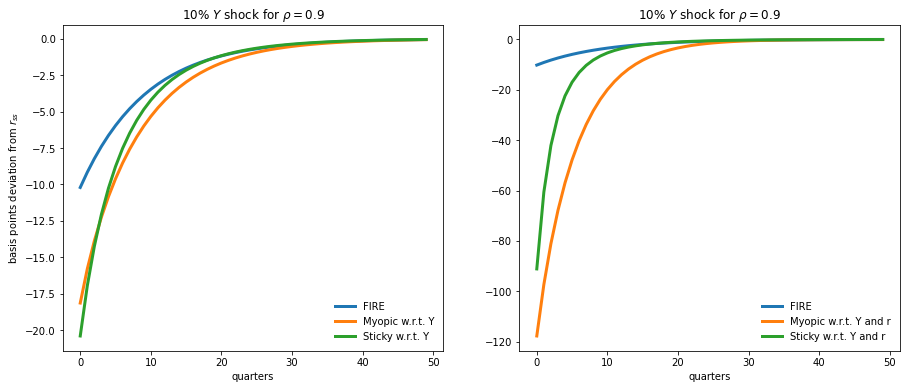

In [14]:
G4   = {'r': np.linalg.solve( M_r , np.eye(T) - Mn_y )}
G5   = {'r': np.linalg.solve( Mn_r , np.eye(T) - Mn_y )}

dr   = np.zeros([T,5])

dY       = 0.01 * ss['Y'] * 0.90 ** (np.arange(T)[:, np.newaxis])
dr[:,0]  = np.transpose( G0['r'] @ dY )
dr[:,1]  = np.transpose( G2['r'] @ dY )
dr[:,2]  = np.transpose( G3['r'] @ dY )
dr[:,3]  = np.transpose( G4['r'] @ dY )
dr[:,4]  = np.transpose( G5['r'] @ dY )

fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))
axes[0].plot( 10000*dr[:50,0] , linewidth=3 , label='FIRE')
axes[0].plot( 10000*dr[:50,1] , linewidth=3 , label='Myopic w.r.t. Y' )
axes[0].plot( 10000*dr[:50,3] , linewidth=3 , label='Sticky w.r.t. Y' )
axes[0].set(title=r'10% $Y$ shock for $\rho= 0.9$', ylabel=r'basis points deviation from $r_{ss}$',
            xlabel = r'quarters')
axes[0].legend(framealpha=0)

axes[1].plot( 10000*dr[:50,0] , linewidth=3 , label='FIRE')
axes[1].plot( 10000*dr[:50,2] , linewidth=3 , label='Myopic w.r.t. Y and r' )
axes[1].plot( 10000*dr[:50,4] , linewidth=3 , label='Sticky w.r.t. Y and r' )
axes[1].set(title=r'10% $Y$ shock for $\rho= 0.9$', xlabel = r'quarters')
axes[1].legend(framealpha=0)

plt.show()